In [1]:
using Pkg, Revise
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
# alternatively, cd into GenLinAlgProblems, start julia, and add the package to dev:   pkg> dev .
using GenLinAlgProblems, LinearAlgebra, RowEchelon, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

  Activating project at `C:\Users\Edgar Auger\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


<div style="float:center;width:100%;text-align:center;">
<strong style="height:15px;color:darkred;font-size:40pt;">Householder Reflections</strong>
</div>

<div>
<div style="float:left;width:30%;"><img src="./Figs/HouseholderReflections.svg" width=300></div>
<div style="float:right;padding-left:2cm;padding-top:1cm;width:60%;">

**Idea:** Reflect a vector onto an elementary basis vector to introduce zeros.

$\qquad$ Given the vector $v = \begin{pmatrix} a \\ b \end{pmatrix}$, reflect it onto $\tilde{v} = \begin{pmatrix} r \\ 0 \end{pmatrix}$
where $r = \sqrt{a^2 + b^2}$.

<br>
    
**Remark:** there are actually two choices for that basis vector:<br>$\qquad$ we could also reflect the vector $v$ onto $\left( \begin{array}{r} - r \\ 0 \end{array} \right)$
where $r = \sqrt{a^2 + b^2}$.<br><br>

**Remark:** This generalizes to column vectors with a **first entry** $\mathbf{a}$ and a **vector** $\mathbf{b}$.
</div>
</div>

# 1. Reflection Onto an Elementary Basis Vector

## 1.1 The Line of Reflection

#### **Reflected Vector** $\mathbf{\tilde{v}=\begin{pmatrix} r \\ 0 \end{pmatrix}}$

Consider the parallelogram formed by the two vectors  $v = \begin{pmatrix} a \\ b \end{pmatrix}$ and $\tilde{v} = \begin{pmatrix} r \\ 0 \end{pmatrix}$.

$\qquad$ A direction vector of the line of reflection is given by $w = \begin{pmatrix} a \\ b \end{pmatrix} + \begin{pmatrix} r \\ 0 \end{pmatrix}$

#### **Reflected Vector** $\mathbf{\tilde{v}=-\begin{pmatrix} r \\ 0 \end{pmatrix}}$

Consider the parallelogram formed by the two vectors  $\begin{pmatrix} a \\ b \end{pmatrix}$ and $\begin{pmatrix} -r \\ 0 \end{pmatrix}$.

$\qquad$ A direction vector of the line of reflection is given by $w = \begin{pmatrix} a \\ b \end{pmatrix} + \begin{pmatrix} -r \\ 0 \end{pmatrix} = \begin{pmatrix} a \\ b \end{pmatrix} - \begin{pmatrix} r \\ 0 \end{pmatrix}$

#### **Reflected Vector Choice**

For numerical reasons, one usually chooses the the reflection point furthest from the input point,<br>
$\qquad$i.e., in the opposite quadrant:

$$
w = \begin{pmatrix} a \\ b \end{pmatrix} - sign(a) \begin{pmatrix} r \\ 0 \end{pmatrix}
$$

> **Example:**
Given $v = \left( \begin{array}{r} -3 \\ 2 \end{array}\right)$, choose $w = - \begin{pmatrix} r \\ 0 \end{pmatrix},$<br><br>
$\qquad$ where $r = \sqrt{ 3^2 + 2^2 } = \sqrt{13}$.

## 1.2 Householder Matrices

A Householder matrix is a reflection matrix about a line with direction vector $w$.<br>It is given by

$
\qquad H_w = I - 2\ \frac{w w^t}{ w^t w } = I - 2\ \hat{w} \hat{w}^t
$

**Properties**
* $H_w^t = H_w$
* $H_w^{-1} = H_w\quad$ thus $\quad H_w^2 = I$ and $H_w^t H_w = I$<br><br>
$\begin{align} H_w^2 =&\ \left(I - 2\ \hat{w} \hat{w}^t \right)\;
                         \left(I - 2\ \hat{w} \hat{w}^t \right) \\
=&\ I - 4\ \hat{w} \hat{w}^t + 4\ \hat{w} \ \left( \hat{w}^t \hat{w} \right)\ \hat{w}^t \\
=&\ I \qquad \text{ since }\quad \hat{w}^t \hat{w} = 1 \\ 
\end{align}$

$\therefore\quad$ Householder Matrices are **Orthogonal Matrices**

# 2. Householder Reflection Algorithm

Successively apply Householder Matrices to reduce a matrix $A$ to row echelon form.

Given a matrix $A$, apply a Householder matrix $H_v$ with $v$ equal to the first column of $A$,<br>
$\qquad$then apply this transformation recursively to submatrices of $A$ obtained by removing the first row and column of the matrix.

This amounts to successivly applying matrices of the form $\begin{pmatrix} I & 0 \\ 0 & H_v \end{pmatrix}$<br>
$\qquad$ with $I$ increasing in size at each successive step.

____
The following code augments the matrix $A$ by $I$ to keep track of the product $H$ of Householder matrices<br>
$\qquad$ applied to $A$ to obtain the row echelon form $R$, i.e.,  $R = H A$.

$\qquad$ At each step it computes $\begin{pmatrix} I & 0 \\ 0 & H_v \end{pmatrix}$ rather than just $H_v$

In [65]:
function naive_householder( A; tol = :none )
    # naive implementation
    e = eltype(A)
    if tol == :none tol = zero(e) end

    function sgn(x)
        x != zero(e) ? sign(x) : one(e)
    end

    m,n = size(A)
    AI  = [copy(A) one(e)I(m)]

    matrices = [ [:none, AI ] ]

    i = 1; j = 1
    while i < m && j <= n
        v         = AI[:,j]                                  # original vector
        v[1:i-1] .= zero(e)                                  # keep only the part of the vector we are working with
        len_v     = sqrt(v'v)
        if (len_v - abs(v[i])) > tol                         # non-zero values below current pivot position
            ṽ     = zeros(e,m); ṽ[i] = - sgn(v[i]) * len_v   # reflected vector (if v[j] = 0, we set the sign to 1)

            w     = v + ṽ                                    # bisector
            Q     = I(m) - 2*w*w' / (w'w)                    # reflection matrix  (note this assumes v ≠ 0)
            AI    = Q*AI                                     # update the matrix

            push!(matrices, [Q, copy(AI)] )
            i += 1
        end
        j += 1
    end

    return matrices
end;

## 2.1 Small Example with Rationals

In [73]:
Random.seed!(12242)
function nice_A(m,n,r; maxint=3)
    Q = Q_matrix(m)
    R,_ = ref_matrix(m,n,r; maxint=maxint)
    SymPy.Sym.(Q*R)
end
A=nice_A(3,4,3);
latexify(A)

L"\begin{equation}
\left[
\begin{array}{cccc}
\frac{-36}{13} & 0 & -2 & \frac{-164}{13} \\
\frac{15}{13} & 0 & 3 & \frac{12}{13} \\
0 & 2 & -2 & -2 \\
\end{array}
\right]
\end{equation}
"

In [74]:
matrices = naive_householder(A)
R        = matrices[end][2][:,1:size(A,2)]
Q        = matrices[end][2][:,size(A,2)+1:end]'
println( "A ≈ Q R    is  $(A ≈ Q*R)" )

A ≈ Q R    is  true


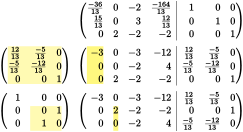

In [75]:
h,_=nM.ge( to_latex(matrices), formater=x->x, Nrhs=size(A,1),
    bg_for_entries=[
        [1, 0, [[(0, 0), (2, 2)]], "yellow!30"],[1, 1, [[(0, 0), (2, 0)]], "yellow!50"],
        [2, 0, [[(1, 1), (2, 2)]], "yellow!30"],[2, 1, [[(1, 1), (2, 1)]], "yellow!50"],
    ],
    tmp_dir="/tmp")
h

## 2.2 Floating Point Example

In [76]:
Random.seed!(14225)
A = Float64.(nice_A(5,4,3; maxint=3))
matrices = naive_householder(A; tol=1e-10)
R        = matrices[end][2][:,1:size(A,2)]
Q        = matrices[end][2][:,size(A,2)+1:end]'
println( "A ≈ Q R    is  $(A ≈ Q*R)" )

A ≈ Q R    is  true


Reverting Windows console CPs to (in,out) = (437,437)


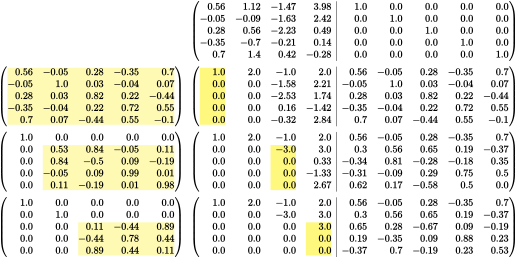

In [77]:
h,m=nM.ge( round_matrices( matrices,2), Nrhs=size(A,1),
    bg_for_entries=[
        [1, 0, [[(0, 0), (4, 4)]], "yellow!30"],[1, 1, [[(0, 0), (4, 0)]], "yellow!50"],
        [2, 0, [[(1, 1), (4, 4)]], "yellow!30"],[2, 1, [[(1, 2), (4, 2)]], "yellow!50"],
        [3, 0, [[(2, 2), (4, 4)]], "yellow!30"],[3, 1, [[(2, 3), (4, 3)]], "yellow!50"],
#        [4, 0, [[(3, 3), (4, 4)]], "yellow!30"],[4, 1, [[(3, 3), (4, 3)]], "yellow!30"],
    ],
    tmp_dir="/tmp")
h

## 2.3 Remark: this is a QR Decomposition

In [10]:
round.(Q'Q, digits=10)

5×5 Matrix{Float64}:
  1.0   0.0  -0.0   0.0  0.0
  0.0   1.0  -0.0  -0.0  0.0
 -0.0  -0.0   1.0   0.0  0.0
  0.0  -0.0   0.0   1.0  0.0
  0.0   0.0   0.0   0.0  1.0

In [13]:
Q'Q ≈ I

true